# Classification challenge

## Setting the paths, importing the libraries and the data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


notebook = 'classification.ipnyb'
path = os.path.dirname(os.path.abspath(notebook))+'/data/'
train_path = path+'classification_train.csv'
test_path = path+'classification_test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head()

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


## Exploratory analysis

There is little info about this data but we can still explore it a little bit:
* null/missing values
* variables distribution
* variable correlation
* distribution according to the target variable

In [3]:
#Constructing a trainframe with the variable types and missing values per column
consistency = pd.DataFrame({'columns' : train.columns,
                    'type': train.dtypes,
                    'missing' : train.isna().sum(),
                    'size' : train.shape[0],
                    'unique': train.nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
x1,x1,float64,0,670,670,0.0
x2,x2,float64,0,670,670,0.0
target,target,int64,0,670,2,0.0


There are no missing values, so nothing needs to be done here.

array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

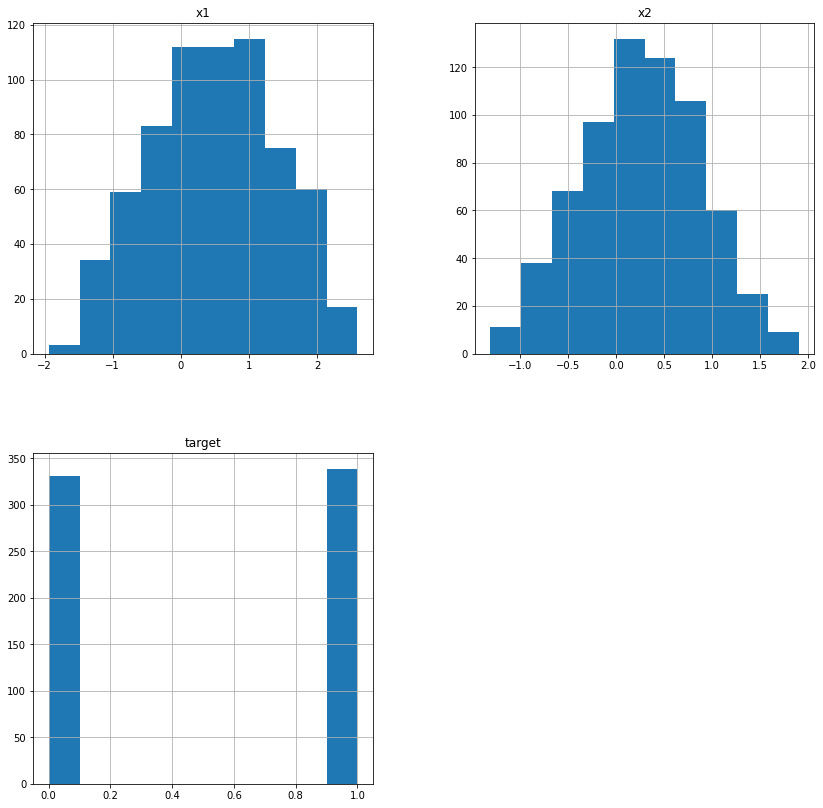

In [4]:
train.hist(figsize=(14,14))

The variables seem to have been standarized, which means that the test set has to be transformed as well, we will check this afterwards.

The target variable is balanced, so no further processing is needed here.

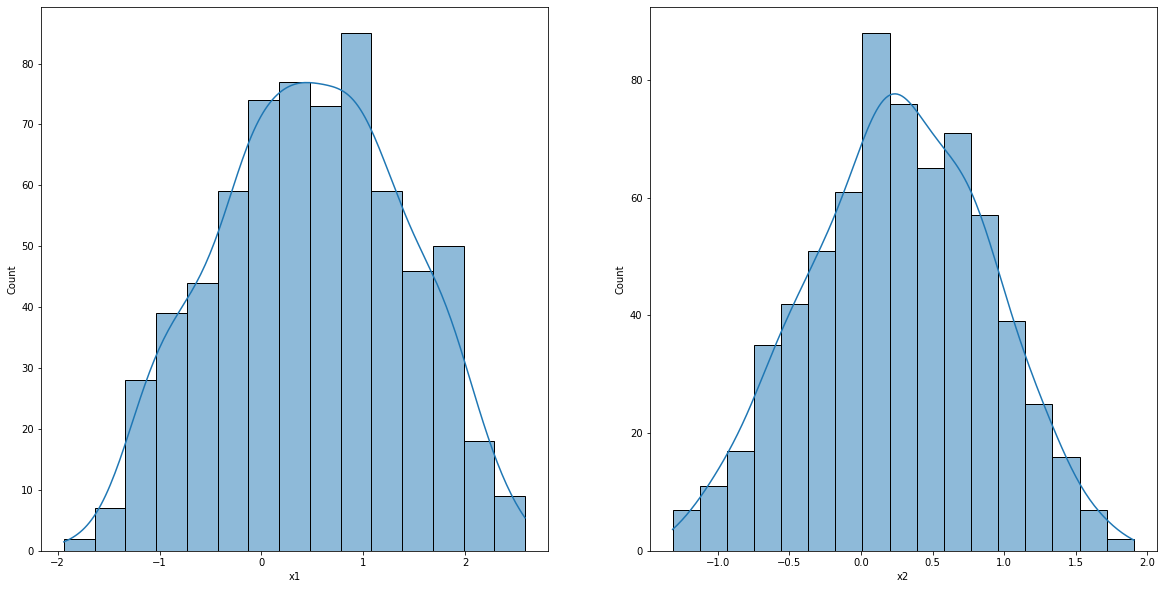

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for variable, subplot in zip(['x1','x2'], ax.flatten()):
    sns.histplot(train[variable], ax=subplot,kde=True)

Same plots as above but with different looks.

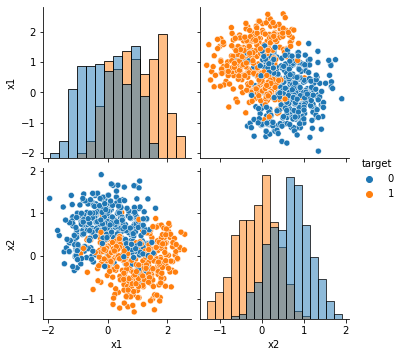

In [6]:
sns.pairplot(train, kind="scatter", hue='target', diag_kind="hist")
plt.show()

Looks like the relation between the variables and the target is somewhat separated.

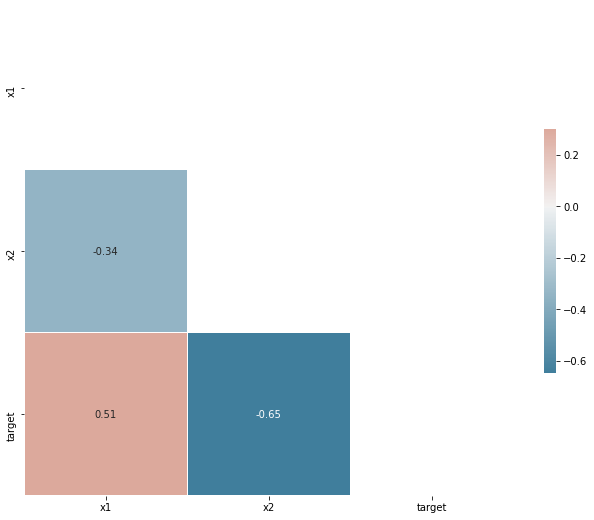

In [7]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

The target variable is a inversely related to x2, which means as x2 the probability of the target being 0 increases as well.

x1 and x2 are also inversely related while x1 and the target variables vary in the same direction.

In [8]:
test.head()

,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


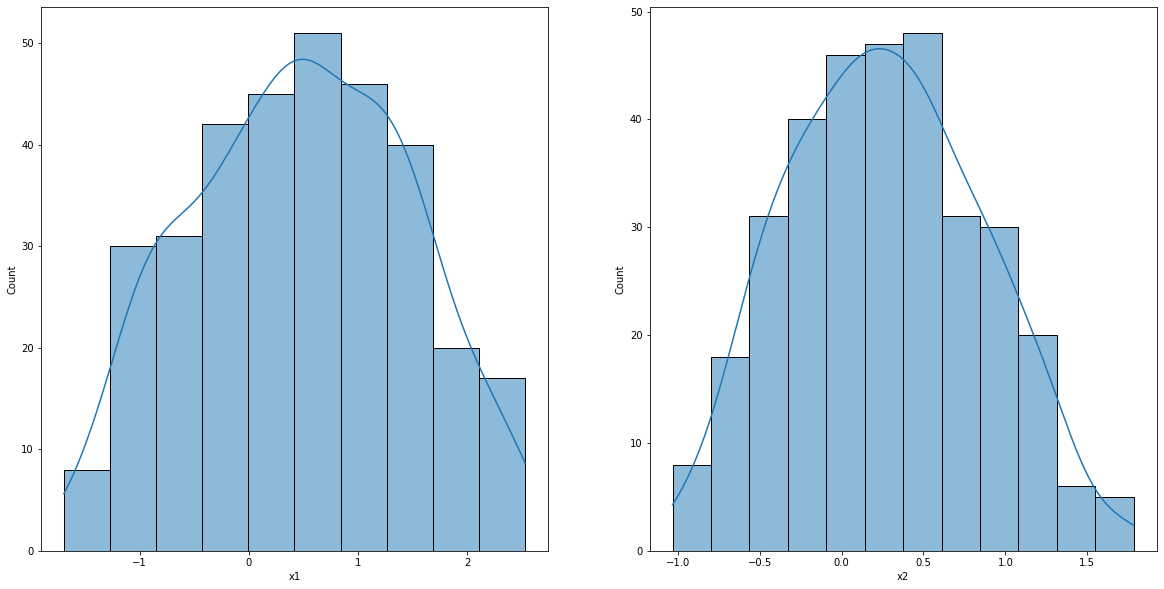

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for variable, subplot in zip(['x1','x2'], ax.flatten()):
    sns.histplot(test[variable], ax=subplot,kde=True)

array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x2'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

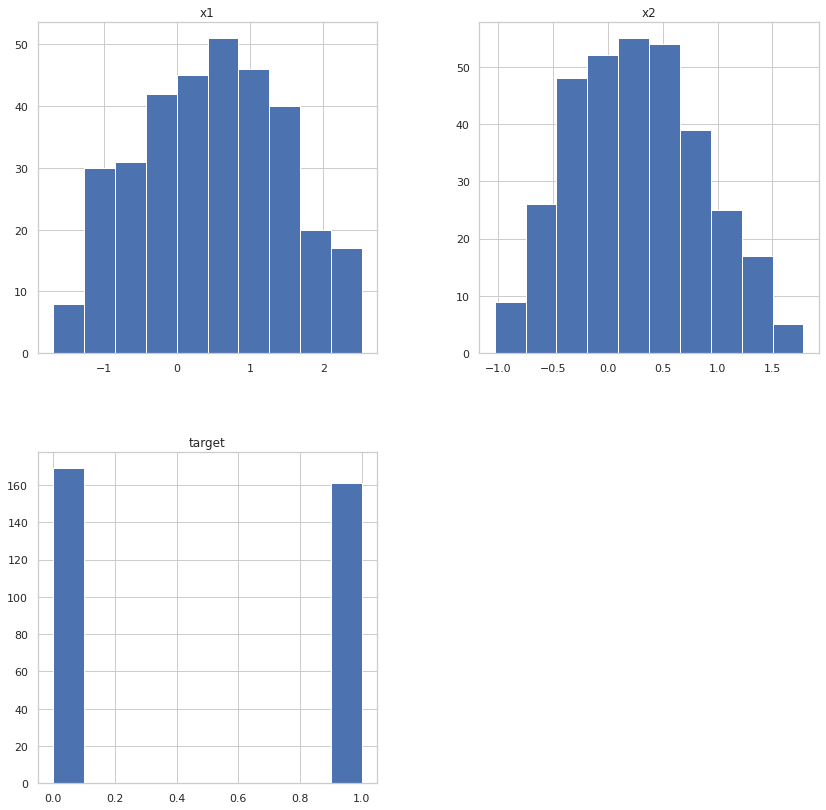

In [39]:
test.hist(figsize=(14,14))

The test variable has been transformed as well. So we can proceed.

 Let's run a Kolmogorov-Smirnov test to verify the train and test samples come from the same distribution.

In [53]:
from scipy import stats

print('X1: ' + str(stats.ks_2samp(train.x1, test.x1)))
print('X2: ' + str(stats.ks_2samp(train.x2, test.x2)))

X1: KstestResult(statistic=0.046359113523292625, pvalue=0.7060960980278901)
X2: KstestResult(statistic=0.04269561284486657, pvalue=0.7940994864181903)


All p-values are above 10% so we cannot reject the null hypothesis (the sets come from the same distribution).

## Separating the target variables

In [10]:
X_train = train[['x1','x2']]
X_test = test[['x1','x2']]
y_train = train['target']
y_test = test['target']

X_train

,x1,x2
0,1.934224,-0.111822
1,1.767383,-0.976402
2,0.937101,-0.085633
3,1.340732,0.166960
4,-0.199901,-0.155204
...,...,...
665,0.690181,-0.800060
666,1.043712,-0.212964
667,1.821542,-0.406377
668,0.031938,1.424103


## Setting the seeds for reproducibility

In [11]:
import random 

seed_value = 42
random.seed(seed_value) 
np.random.seed(seed_value)

## Model training and evaluation

We'll start with a more simple classification model such as Logistic Regression to set a baseline and go from there.

## Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
 
lr = LogisticRegression(random_state=seed_value)
lr.fit(X_train,y_train)

LogisticRegression(random_state=42)

## Model comparison metrics

The evalaution metrics have already been set:
* precision, 
* recall,
* and F2-score.

We will add AUC and also the confusion matrix.

Recall: 85.09%
Precision: 81.55
F2-Score: 84.36%
AUC Score: 0.83
Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       169
           1       0.82      0.85      0.83       161

    accuracy                           0.83       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.83      0.83      0.83       330



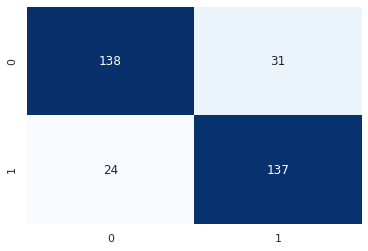

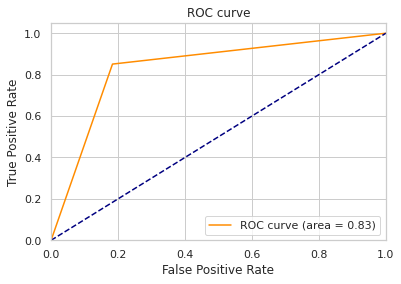

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_pred = lr.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
f2_test = fbeta_score(y_test, y_pred, beta=2)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("F2-Score: %.2f%%" % (f2_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Now that we have a baseline we'll move to other models like random forest classifier.

## Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=seed_value)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

Recall: 86.96%
Precision: 85.37
F2-Score: 86.63%
AUC Score: 0.86
Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       169
           1       0.85      0.87      0.86       161

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



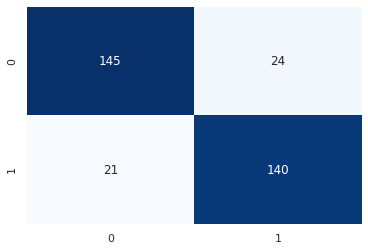

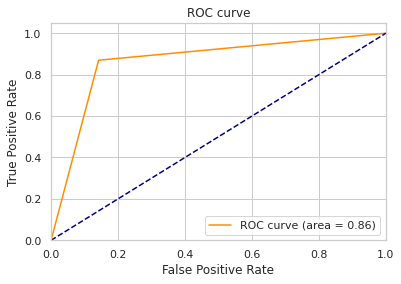

In [43]:
y_pred = rfc.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
f2_test = fbeta_score(y_test, y_pred, beta=2)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("F2-Score: %.2f%%" % (f2_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

All three metrics have improved.
We can peform a gridsearch to try to improve these metrics.

## Hyperparemeter GridSearch

In [18]:
from sklearn.model_selection import GridSearchCV

#Since it's a binary classification problem we will use AUC as the parameter for scoring


param_test1 = {
    'bootstrap':[True,False],
    'n_estimators':[10,25,50,75,100,150],
    'criterion':['gini', 'entropy'],
    'max_depth':[2,4,6,8],
    'min_samples_split':[2,3,4,5,6] ,
    'min_samples_leaf':[1,2,3,4,5],
    'max_features':['auto','sqrt','log2'],
    'oob_score':[True,False],
    'class_weight':['balanced','balanced_subsample',None],
    'random_state':[seed_value]

}

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state=seed_value), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 43200 candidates, totalling 216000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1898 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 2788 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3842 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5056 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 6434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7972 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9674 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 11536 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 13562 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 15748 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 18098 tasks   

({'bootstrap': True,
  'class_weight': 'balanced_subsample',
  'criterion': 'gini',
  'max_depth': 6,
  'max_features': 'auto',
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'n_estimators': 25,
  'oob_score': True,
  'random_state': 42},
 0.9504698254278928)

## Fine Tuning

In [20]:
param_test2 = {
    'n_estimators':[15,20,25,30,35,40],
    'max_depth':[5,6,7],
    'min_samples_leaf':[3,4,5],
}

gsearch2 = GridSearchCV(estimator = RandomForestClassifier(random_state=seed_value,
                                                           bootstrap= True,
                                                           class_weight= 'balanced_subsample',
                                                           criterion='gini',
                                                           max_depth= 6,
                                                           max_features='auto',
                                                           min_samples_leaf= 4,
                                                           min_samples_split= 2,
                                                           n_estimators=25,
                                                           oob_score= True,
                                     ), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.2s finished


({'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 25},
 0.9504698254278928)

In [44]:
rfc = RandomForestClassifier(random_state=seed_value,
                             bootstrap= True,
                             class_weight = 'balanced_subsample',
                             criterion = 'gini',
                             max_depth= 6,
                             max_features='auto',
                             min_samples_leaf= 4,
                             min_samples_split = 2,
                             n_estimators= 25,
                             oob_score= True
                            )

rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       min_samples_leaf=4, n_estimators=25, oob_score=True,
                       random_state=42)

Recall: 89.44%
Precision: 86.23
F2-Score: 88.78%
AUC Score: 0.88
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       169
           1       0.86      0.89      0.88       161

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



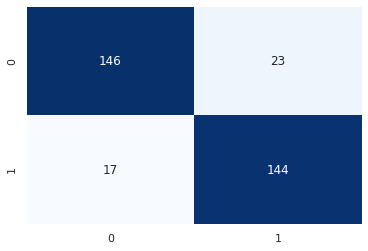

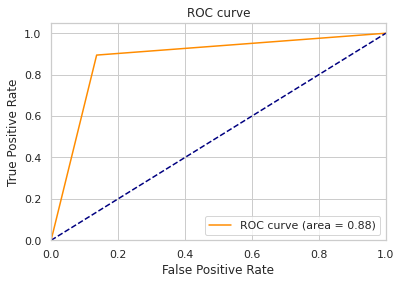

In [45]:
y_pred = rfc.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
f2_test = fbeta_score(y_test, y_pred, beta=2)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("F2-Score: %.2f%%" % (f2_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

All metrics have increased after the hyperparameter tuning.

## Feature importance

We only have two features but we can still take a look at which one is more relevant for the prediction in this model.

In [24]:
importances = rfc.feature_importances_
features_names = []
ordered_importances = []
for i in np.argsort(importances)[::-1]:
    features_names.append(X_test.columns[i])
    ordered_importances.append(importances[i])
    print( X_test.columns[i],"%.4f" % importances[i])

x2 0.5849
x1 0.4151


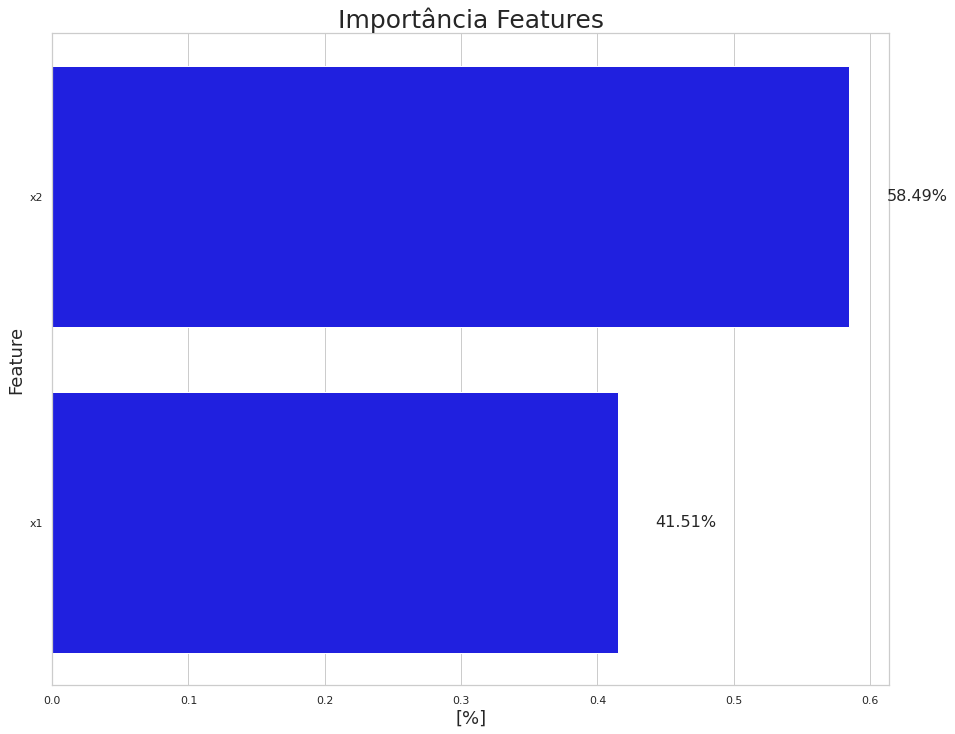

In [28]:
ordered_importances_porcentagem = [(round(element * 100,2))for element in ordered_importances]
f, ax = plt.subplots(figsize=(15, 12))
sns.set(style="whitegrid")
sns.set_color_codes("muted")
sns.barplot(x=ordered_importances,y=features_names,
            label="Features", color="blue")
plt.title('Importância Features',fontsize=25)
plt.xlabel('[%]',fontsize=18)
plt.ylabel('Feature',fontsize=18)

for i in range (0,len(ordered_importances)):
    
    plt.text(x=ordered_importances[i]+0.05, y=i , s=str(round(ordered_importances[i]*100,2))+'%'
             ,horizontalalignment='center',verticalalignment='center', fontsize=16)

plt.show()

## Support Vector Machine

While looking at the pairplots the variables seem linearly separable. So SVM might be a better choice.

In [46]:
from sklearn.svm import SVC

svc = SVC(random_state=seed_value)
svc.fit(X_train,y_train)

SVC(random_state=42)

Recall: 89.44%
Precision: 85.71
F2-Score: 88.67%
AUC Score: 0.88
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       169
           1       0.86      0.89      0.88       161

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



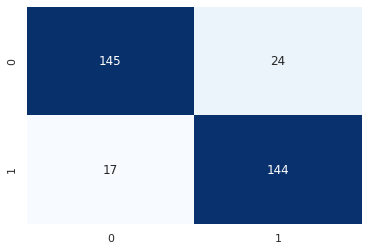

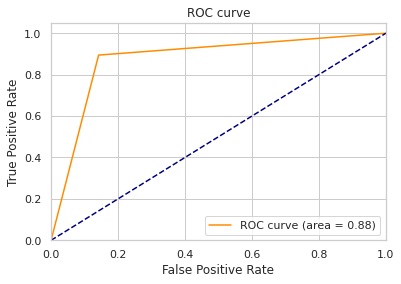

In [47]:
y_pred = svc.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
f2_test = fbeta_score(y_test, y_pred, beta=2)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("F2-Score: %.2f%%" % (f2_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

SVM default parameters showed a very similar performance to random forest, so we can try to tweak the parameters to see if it's better.

In [35]:
param_test3 = {
    'C': [1, 10], 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[2,3,4],
    'gamma': ['scale', 'auto'],
    'shrinking':[True,False],
    'class_weight':['balanced',None],
    'decision_function_shape':['ovo', 'ovr'],
    'random_state':[seed_value]

}

gsearch3 = GridSearchCV(estimator = SVC(), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:    6.0s finished


({'C': 10,
  'class_weight': None,
  'decision_function_shape': 'ovo',
  'degree': 2,
  'gamma': 'auto',
  'kernel': 'rbf',
  'random_state': 42,
  'shrinking': True},
 0.9504698254278928)

In [48]:
svc = SVC(C= 10, 
          class_weight = None,
          decision_function_shape = 'ovo',
          degree = 2,
          gamma = 'auto',
          kernel = 'rbf',
          random_state = seed_value,
          shrinking = True) 

svc.fit(X_train,y_train)

SVC(C=10, decision_function_shape='ovo', degree=2, gamma='auto',
    random_state=42)

Recall: 88.20%
Precision: 87.12
F2-Score: 87.98%
AUC Score: 0.88
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       169
           1       0.87      0.88      0.88       161

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



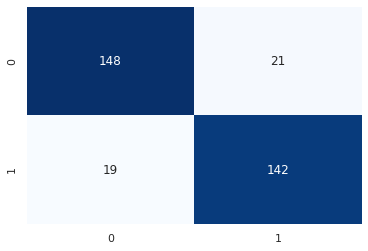

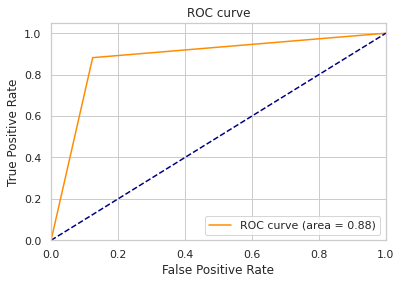

In [49]:
y_pred = svc.predict(X_test)
# evaluate predictions
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
f2_test = fbeta_score(y_test, y_pred, beta=2)
auc_test = roc_auc_score(y_test, y_pred)

print("Recall: %.2f%%" % (recall_test * 100.0))
print("Precision: %.2f" % (precision_test * 100.0))
print("F2-Score: %.2f%%" % (f2_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## Summary

In [51]:
summary = pd.DataFrame(np.array([[85.09, 81.55, 84.36, 0.83], [89.44, 85.71, 88.67, 0.88], [88.20, 87.12, 87.98, 0.88]]), 
                       index=['Logistic Regression','Random Forest', 'SVC'],
                       columns=['Recall', 'Precision', 'F2-Score','AUC Score'])

summary

,Recall,Precision,F2-Score,AUC Score
Logistic Regression,85.09,81.55,84.36,0.83
Random Forest,89.44,85.71,88.67,0.88
SVC,88.20,87.12,87.98,0.88


## Conclusion

At this point I would compare the metrics against the goal of the model.

However since no details are given about the features or what the models represents, there is no clue about which evaluation metric is more relevant.

With that in mind I would proceed with SVM because it showed the most balanced metrics and the data looks like linearly separable.

Yet, for example, if the business need required an higher Recall, Random Forest would be a better choice.

Finally, if more details were known, other models as well as other features could be explored.